In [1]:
#IMPORT STATEMENTS
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# **HYPERPARAMETERS**

In [2]:
#HyperParameters
IMG_HEIGHT, IMG_WIDTH = 129,129
SEQUENCE_LENGTH = 10  # Number of frames per video
BATCH_SIZE =35
EPOCHS = 50
NUM_CLASSES = 2

# **DATA AUGMENTATION**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# **EXTRACT FRAMES FROM VIDEO**

In [4]:

# Function to extract frames from a video
def extract_frames(video_path, datagen):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < SEQUENCE_LENGTH:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))

        # Apply data augmentation to the frame
        frame = np.expand_dims(frame, axis=0)  # Add a batch dimension
        augmented_frames = datagen.flow(frame, batch_size=1)
        augmented_frame = augmented_frames[0][0]  # Extract the augmented frame

        frames.append(augmented_frame)
    cap.release()
    if len(frames) == SEQUENCE_LENGTH:
        return np.array(frames)
    return None

# **LOAD VIDEOS FROM FOLDER**

In [5]:
# Function to load videos from folders
def load_videos_from_folder(folder_path, label, datagen):
    videos = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):  # Assuming videos are in .mp4 format
            video_path = os.path.join(folder_path, filename)
            frames = extract_frames(video_path, datagen)  # Pass datagen argument here
            if frames is not None:
                videos.append(frames)
                labels.append(label)
    return videos, labels

In [6]:
# Load videos from folders
violent_videos, violent_labels = load_videos_from_folder('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence', label=1, datagen=datagen)
non_violent_videos, non_violent_labels = load_videos_from_folder('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence', label=0, datagen=datagen)

In [7]:
# Combine and Normalize
X = np.array(violent_videos + non_violent_videos) / 255.0
Y = np.array(violent_labels + non_violent_labels)


In [8]:
print("Shape of X:",X.shape)
print("Shape of Y",Y.shape)

Shape of X: (1951, 10, 129, 129, 3)
Shape of Y (1951,)


In [9]:
#IMPORT STATEMENTS
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,LSTM,TimeDistributed, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.layers import BatchNormalization

# **SPLITING THE DATASET**

In [10]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [11]:
# Import necessary libraries
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add

# Define the Transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# **MobileNetV2**

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet= MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-50]:
  layer.trainable=False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)
cnn_model = Model(inputs=mobilenet.input, outputs=x)

/tmp/ipykernel_30/376838851.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet= MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **COMBINE CNN AND Transformer**

In [13]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalMaxPooling1D

# Define the full model architecture
model = Sequential()
model.add(TimeDistributed(cnn_model, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))

# First TimeDistributed layer
model.add(TimeDistributed(Dense(512, activation="relu", kernel_regularizer=l2(0.01))))  # Keep at 512
model.add(BatchNormalization())
model.add(Dropout(0.6))  # Increased Dropout rate

# Transformer block
model.add(TransformerBlock(embed_dim=512, num_heads=8, ff_dim=64, rate=0.1))  # Set embed_dim to 512

# Convolutional layer after the transformer for better feature extraction
model.add(TimeDistributed(Dense(256, activation='relu', kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Pooling layer
model.add(GlobalMaxPooling1D())

# Final layers
model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **SUMMARY**

In [14]:
#model.summary()

In [15]:
#from tensorflow.keras.utils import plot_model
# Visualize and save the model architecture
#plot_model(model, to_file="model.jpg", show_shapes=True)

# **COMPILE THE MODEL**

In [16]:
# Compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# **CALLBACKS**

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
                monitor='val_loss',  
                patience=10, 
                restore_best_weights=True,
                verbose=1)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.4,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode
    min_lr=0.0005        # Lower bound on the learning rate
)

# **Train the Model**

In [19]:
# Train the model
history=model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2,callbacks=[early_stopping,reduce_lr])

Epoch 1/50


I0000 00:00:1730028670.983569    7904 service.cc:145] XLA service 0x79e76c0023c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730028670.983639    7904 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730028670.983643    7904 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730028699.890195    7932 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_84', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1730028700.781171    7934 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 1240 bytes spill stores, 1200 bytes spill loads

I0000 00:00:1730028701.740398    7931 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_84', 1900 bytes spill stores, 1884 bytes spill loads

I0000 00:00:17300

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6190 - loss: 11.9254

I0000 00:00:1730028772.354139    7976 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_84', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1730028774.844012    7977 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 1240 bytes spill stores, 1200 bytes spill loads



36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6206 - loss: 11.9185   

I0000 00:00:1730028845.773851    8018 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 1240 bytes spill stores, 1200 bytes spill loads



36/36 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.6222 - loss: 11.9120 - val_accuracy: 0.5481 - val_loss: 11.5401 - learning_rate: 0.0100
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.8305 - loss: 11.0212 - val_accuracy: 0.6026 - val_loss: 11.3792 - learning_rate: 0.0100
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.8920 - loss: 10.7030 - val_accuracy: 0.6923 - val_loss: 11.1658 - learning_rate: 0.0100
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9220 - loss: 10.4815 - val_accuracy: 0.8429 - val_loss: 10.6292 - learning_rate: 0.0100
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.9568 - loss: 10.2406 - val_accuracy: 0.8718 - val_loss: 10.4095 - learning_rate: 0.0100
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.9688 - loss: 10.0629 - val_accuracy: 0.8910 - val_loss: 10.2182 - learning_rate: 0.0100
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.9688 - loss: 9.9011 - 

# **Accuracy Curve**

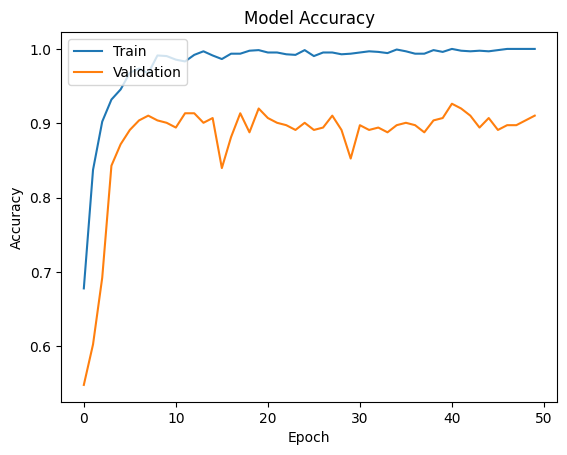

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("accuracy_curve.jpg")  # Save the figure before showing it
plt.show()  # Display the plot

# **Loss Curve**

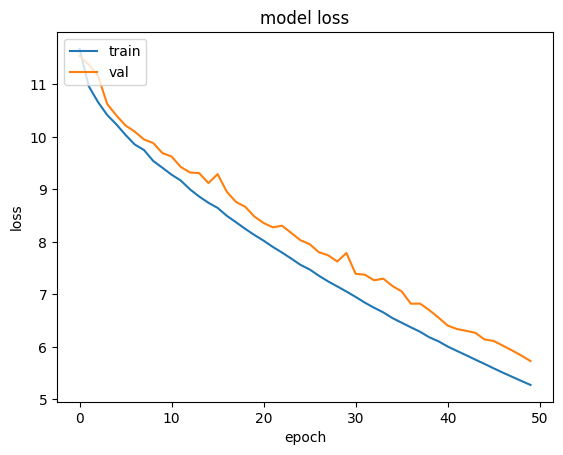

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_curve.jpg")
plt.show()

In [22]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9275 - loss: 5.6275

I0000 00:00:1730029312.630680    8830 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 952 bytes spill stores, 948 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9284 - loss: 5.6226 
Test Accuracy: 0.93


In [23]:
pred=model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


In [24]:
pred.shape

(391, 1)

# **Confusion Matrix**

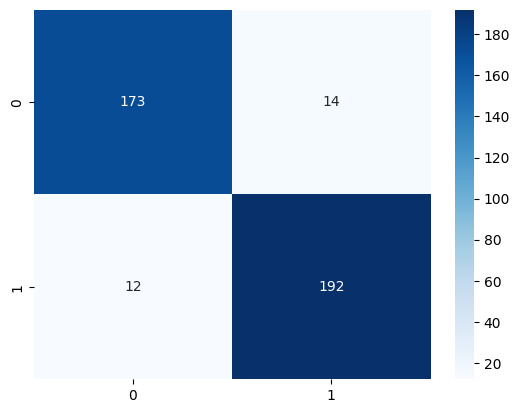

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predicted probabilities to binary values (0 or 1)
pred_binary = (pred > 0.5).astype(int)

cm = confusion_matrix(y_test, pred_binary)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues")
plt.savefig("confusion_matrix.jpg")

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_binary))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       187
           1       0.93      0.94      0.94       204

    accuracy                           0.93       391
   macro avg       0.93      0.93      0.93       391
weighted avg       0.93      0.93      0.93       391



In [27]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision:",precision_score(y_test,pred_binary))
print("Recall:",recall_score(y_test,pred_binary))
print("F1-Score:",f1_score(y_test,pred_binary))

Precision: 0.9320388349514563
Recall: 0.9411764705882353
F1-Score: 0.9365853658536586


In [28]:
 #Save the model
model.save('violence_detection_MobileNet_Transformer_model.h5')